In [3]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2

## Data Preprocessing

In [4]:
from utils.preprocessing import get_mean_std, split_dataset

split_ratio = [0.7, 0.15, 0.15]
mean, std = get_mean_std('dataset_1500', split_ratio=split_ratio, random_seed=2024)

train_transform = transforms.Compose([
    v2.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandAugment(num_ops=2, magnitude=9),
    v2.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    v2.Normalize(mean, std),
])

test_transform = transforms.Compose([
    v2.Normalize(mean, std),
])

train_dataset, val_dataset, test_dataset = split_dataset('dataset_1500',
                                                         train_transform=train_transform,
                                                         test_transform=test_transform,
                                                         split_ratio=split_ratio,
                                                         random_seed=2024)

print(f"mean/std: {mean}/{std}")
print(f"train/val/test size: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}")

Calculating mean and std: 100%|██████████| 99/99 [00:07<00:00, 13.46it/s]


mean/std: tensor([0.4654, 0.4858, 0.4113])/tensor([0.2330, 0.2324, 0.2491])
train/val/test size: 3150/675/675


## Create DataLoader

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"train/val/test loader size: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}")

for images, labels in train_loader:
    print(f"images/labels size: {images.size()}/{labels.size()}")
    break

train/val/test loader size: 99/22/22
images/labels size: torch.Size([32, 3, 256, 256])/torch.Size([32])


## Display Images

label map: {0: 'red-billed-blue-magpie', 1: 'taiwan-blue-magpie', 2: 'yellow-billed-blue-magpie'}


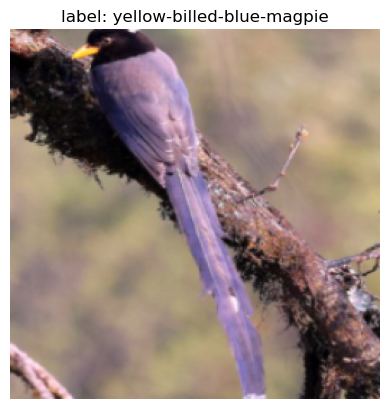

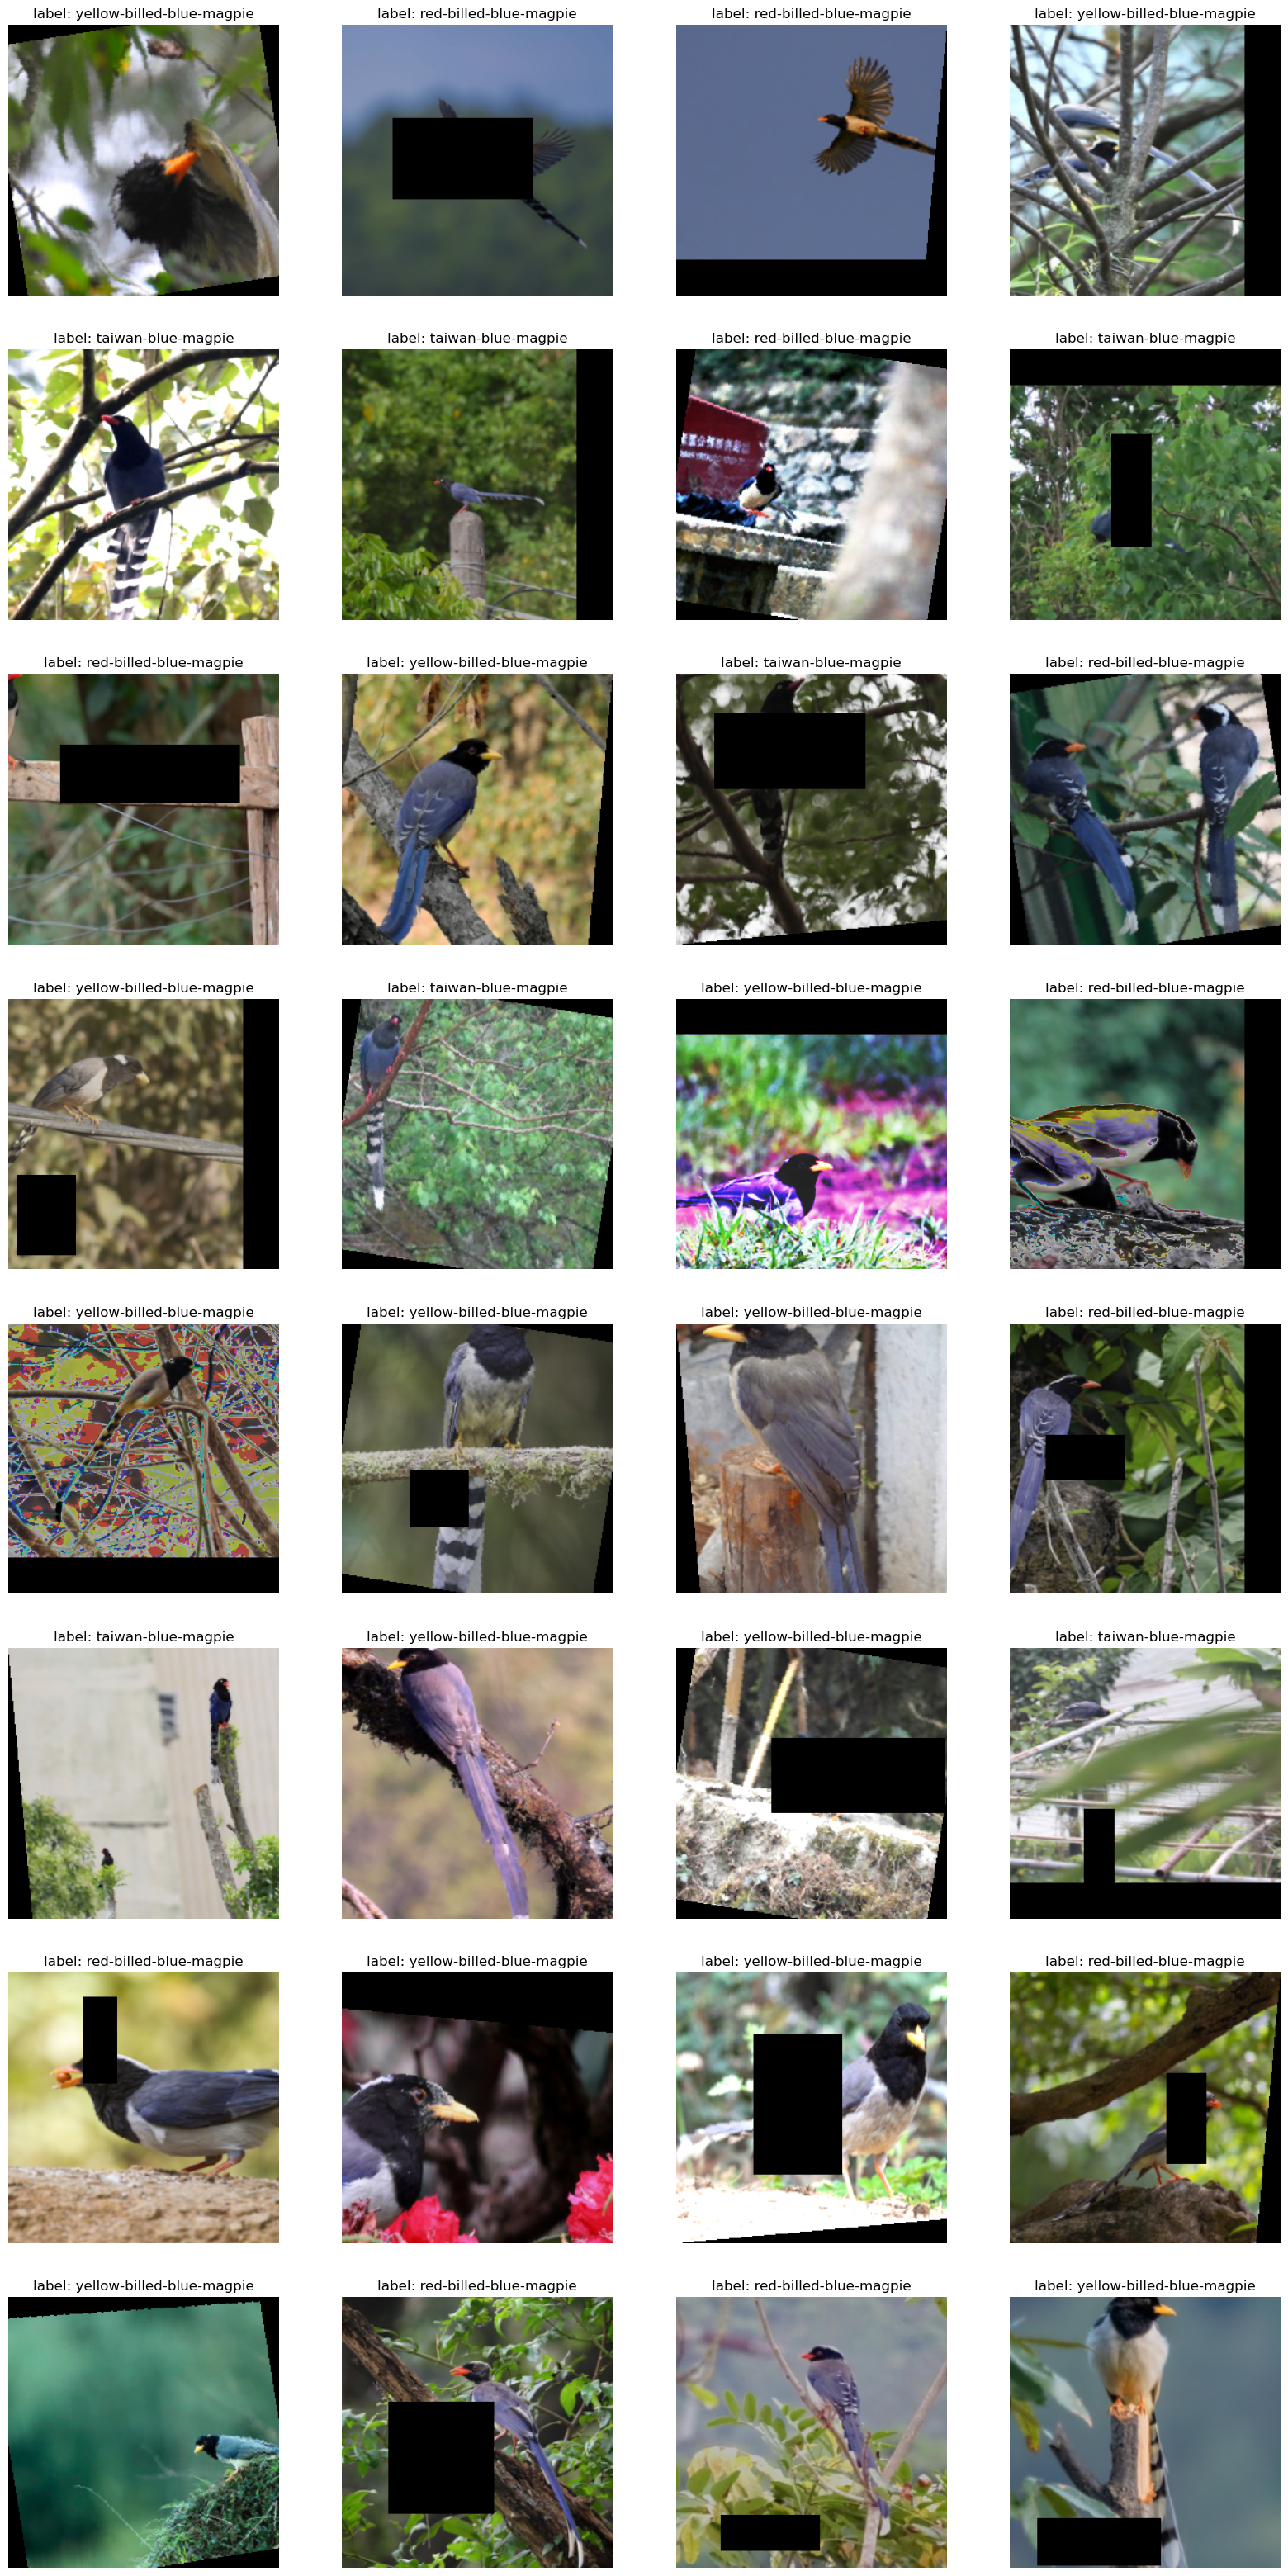

In [6]:
from utils.preprocessing import get_label_map
from utils.plot import plot_single, plot_batch

label_map = get_label_map('dataset_1500')
print(f"label map: {label_map}")

for images, labels in train_loader:
    plot_single(images, labels, label_map, mean, std)
    plot_batch(images, labels, label_map, mean, std)
    break

## Load Pre-Trained EfficientNet Model

In [8]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

model = models.efficientnet_v2_s(weights='DEFAULT')
print(model.classifier)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    torch.nn.Linear(in_features, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(128, 3)
)
print(model.classifier)

model.to(device)

device: cuda
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Linear(in_features=1280, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=3, bias=True)
)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## Define Optimizer, Loss Function, and Scheduler

In [9]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.5)

## Start training

In [ ]:
from training.train import train

train_loss, train_acc, val_loss, val_acc = train(model=model,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 optimizer=optimizer,
                                                 criterion=criterion,
                                                 model_name='effv2s_bn_si_0.001_10_0.5',
                                                 device=device,
                                                 epochs=120,
                                                 scheduler=scheduler)

## Plot Training Graph

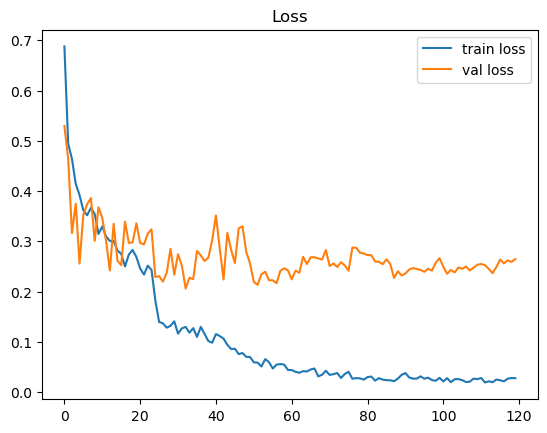

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Loss')
plt.legend()
plt.show()

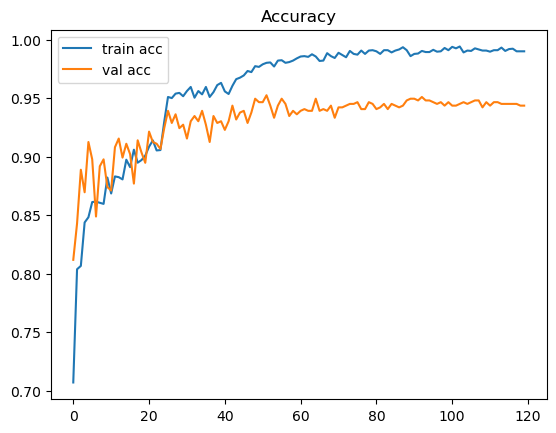

In [12]:
plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()